In [34]:
import pandas as pd
import numpy as np

# Load dataset (Replace 'your_dataset.csv' with your actual dataset)
df = pd.read_csv("preprocessed_covid500_final.csv")

# Randomly select 50 samples
sampled_df = df.sample(n=50, random_state=42)  # Use random_state for reproducibility

# Save the sampled dataset to a new CSV file
sampled_df.to_csv("sampled_dataset.csv", index=False)

print("Sampled dataset saved as 'sampled_dataset.csv'")


Sampled dataset saved as 'sampled_dataset.csv'


In [63]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular
from sklearn.preprocessing import StandardScaler

# Load the sampled test dataset
df = pd.read_csv("sampled_dataset.csv")
print(f"Shape of the dataset: {df.shape}")

ann_features = ['Breathing Problem', 'Sore throat', 'Running Nose', 'Chronic Lung Disease',
                'Headache', 'Heart Disease', 'Diabetes', 'Hyper Tension', 'Attended Large Gathering', 'Gastrointestinal ']
cnn_features = ['Sore throat', 'Breathing Problem', 'Attended Large Gathering', 
                'Family working in Public Exposed Places', 'Heart Disease', 
                'Hyper Tension', 'Chronic Lung Disease', 'Fever', 
                'Dry Cough', 'Running Nose']
lstm_features = ['Breathing Problem', 'Sore throat', 'Running Nose', 
                 'Chronic Lung Disease', 'Heart Disease', 'Hyper Tension', 
                 'Fatigue ', 'Gastrointestinal ', 'Attended Large Gathering', 
                 'Family working in Public Exposed Places']

# All unique features across models
all_features = list(set(ann_features + cnn_features + lstm_features))

# Extract required feature subsets
X_ann = df[ann_features].values
X_cnn = df[cnn_features].values
X_lstm = df[lstm_features].values
X_all = df[all_features].values

# Load the pre-trained models
ann_model = tf.keras.models.load_model("covid_ann_results/final_model_ANN.h5")
cnn_model = tf.keras.models.load_model("covid_cnn_results/final_model_cnn.h5")
lstm_model = tf.keras.models.load_model("covid_lstm_results/final_model_lstm.h5")

print(f"ANN model input shape: {ann_model.input_shape}")
print(f"CNN model input shape: {cnn_model.input_shape}")
print(f"LSTM model input shape: {lstm_model.input_shape}")

# Reshape inputs according to model requirements
X_ann_reshaped = X_ann.reshape(X_ann.shape[0], 10, 1, 1)
X_cnn_reshaped = X_cnn.reshape(X_cnn.shape[0], 2, 5, 1)
X_lstm_reshaped = X_lstm.reshape(X_lstm.shape[0], 10, 1)

# Create wrapper functions for each model
def ann_predict(x):
    x_reshaped = x.reshape(x.shape[0], 10, 1, 1)
    preds = ann_model.predict(x_reshaped)
    return preds  # Return probabilities

def cnn_predict(x):
    x_reshaped = x.reshape(x.shape[0], 2, 5, 1)
    preds = cnn_model.predict(x_reshaped)
    return preds  # Return probabilities

def lstm_predict(x):
    x_reshaped = x.reshape(x.shape[0], 10, 1)
    preds = lstm_model.predict(x_reshaped)
    return preds  # Return probabilities

# Ensemble prediction function with corrected soft voting
def ensemble_predict(x):
    # Extract features for each model using the correct indices
    ann_indices = [all_features.index(feature) for feature in ann_features]
    cnn_indices = [all_features.index(feature) for feature in cnn_features]
    lstm_indices = [all_features.index(feature) for feature in lstm_features]
    
    x_ann = x[:, ann_indices]
    x_cnn = x[:, cnn_indices]
    x_lstm = x[:, lstm_indices]
    
    # Reshape inputs according to model requirements
    x_ann_reshaped = x_ann.reshape(x_ann.shape[0], 10, 1, 1)
    x_cnn_reshaped = x_cnn.reshape(x_cnn.shape[0], 2, 5, 1)
    x_lstm_reshaped = x_lstm.reshape(x_lstm.shape[0], 10, 1)
    
    # Get probabilities from each model
    ann_prob = ann_model.predict(x_ann_reshaped)
    cnn_prob = cnn_model.predict(x_cnn_reshaped)
    lstm_prob = lstm_model.predict(x_lstm_reshaped)
    
    # Average the probabilities for soft voting
    ensemble_prob = (ann_prob + cnn_prob + lstm_prob) / 3
    
    # Return class probabilities for SHAP/LIME compatibility
    if len(ensemble_prob.shape) == 1 or ensemble_prob.shape[1] == 1:
        # Handle binary classification case
        return np.hstack((1-ensemble_prob, ensemble_prob))
    else:
        # Return probabilities for multi-class
        return ensemble_prob

# Function to get final predictions (class labels)
def get_ensemble_predictions(x):
    probs = ensemble_predict(x)
    return np.argmax(probs, axis=1)

# Implementing SHAP for ensemble model
def explain_with_shap(X_sample, feature_names, num_samples=100):
    # Define a wrapper that returns the positive class probability for binary classification
    def model_prob_wrapper(x):
        probs = ensemble_predict(x)
        return probs[:, 1]  # Return probability of positive class
        
    background_data = X_sample[np.random.choice(X_sample.shape[0], min(100, X_sample.shape[0]), replace=False)]
    explainer = shap.KernelExplainer(model_prob_wrapper, background_data)
    explanation_samples = X_sample[:num_samples]
    shap_values = explainer.shap_values(explanation_samples)
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, explanation_samples, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig("ensemble_shap_summary.png")
    plt.close()
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, explanation_samples, feature_names=feature_names, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig("ensemble_shap_importance.png")
    plt.close()
    
    print("SHAP analysis completed and saved as 'ensemble_shap_summary.png' and 'ensemble_shap_importance.png'")
    
    return shap_values

# Implementing LIME for ensemble model
def explain_with_lime(X_sample, feature_names, class_names=['Negative', 'Positive'], num_samples=5):
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_sample,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    
    samples_to_explain = X_sample[:num_samples]
    
    for i, sample in enumerate(samples_to_explain):
        explanation = explainer.explain_instance(
            sample, 
            ensemble_predict,  # Use the probability function directly
            num_features=len(feature_names)
        )
        
        # Save the explanation as an image
        explanation.save_to_file(f"lime_explanation_{i}.html")
        print(f"LIME explanation for sample {i} saved as 'lime_explanation_{i}.html'.")

# Example usage of the ensemble prediction and explanation functions
if __name__ == "__main__":
    # Make predictions using the ensemble model
    ensemble_predictions = get_ensemble_predictions(X_all)
    print(f"Ensemble predictions: {ensemble_predictions}")

    # Explain the ensemble model using SHAP
    explain_with_shap(X_all, all_features)

    # Explain the ensemble model using LIME
    explain_with_lime(X_all, all_features)

    print("Ensemble model predictions and explanations completed.")

Shape of the dataset: (50, 21)


ANN model input shape: (None, 10, 1, 1)
CNN model input shape: (None, 2, 5, 1)
LSTM model input shape: (None, 10, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step
Ensemble predictions: [0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1
 1 0 1 0 0 0 0 1 1 0 0 0 1]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular
from sklearn.metrics import accuracy_score

# Load the sampled test dataset
df = pd.read_csv("sampled_dataset.csv")
print(f"Shape of the dataset: {df.shape}")

# Define feature sets for each model
ann_features = ['Breathing Problem', 'Sore throat', 'Running Nose', 'Chronic Lung Disease',
                'Headache', 'Heart Disease', 'Diabetes', 'Hyper Tension', 'Attended Large Gathering', 'Gastrointestinal ']
cnn_features = ['Sore throat', 'Breathing Problem', 'Attended Large Gathering', 
                'Family working in Public Exposed Places', 'Heart Disease', 
                'Hyper Tension', 'Chronic Lung Disease', 'Fever', 
                'Dry Cough', 'Running Nose']
lstm_features = ['Breathing Problem', 'Sore throat', 'Running Nose', 
                 'Chronic Lung Disease', 'Heart Disease', 'Hyper Tension', 
                 'Fatigue ', 'Gastrointestinal ', 'Attended Large Gathering', 
                 'Family working in Public Exposed Places']
bigru_features = ['Breathing Problem', 'Sore throat', 'Running Nose', 'Chronic Lung Disease',
                  'Headache', 'Heart Disease', 'Diabetes', 'Gastrointestinal ',
                  'Attended Large Gathering', 'Family working in Public Exposed Places']

# All unique features across models
all_features = list(set(ann_features + cnn_features + lstm_features + bigru_features))

# Extract required feature subsets
X_ann = df[ann_features].values
X_cnn = df[cnn_features].values
X_lstm = df[lstm_features].values
X_bigru = df[bigru_features].values
X_all = df[all_features].values

# Load the pre-trained models
ann_model = tf.keras.models.load_model("covid_ann_results/final_model_ANN.h5")
cnn_model = tf.keras.models.load_model("covid_cnn_results/final_model_CNN.h5")
lstm_model = tf.keras.models.load_model("covid_lstm_results/final_model_lstm.h5")
bigru_model = tf.keras.models.load_model("covid_bigru_results/final_model_BiGRU.h5")

print(f"ANN model input shape: {ann_model.input_shape}")
print(f"CNN model input shape: {cnn_model.input_shape}")
print(f"LSTM model input shape: {lstm_model.input_shape}")
print(f"BiGRU model input shape: {bigru_model.input_shape}")

# Reshape inputs according to model requirements
X_ann_reshaped = X_ann.reshape(X_ann.shape[0], 10, 1, 1)
X_cnn_reshaped = X_cnn.reshape(X_cnn.shape[0], 2, 5, 1)
X_lstm_reshaped = X_lstm.reshape(X_lstm.shape[0], 10, 1)
X_bigru_reshaped = X_bigru.reshape(X_bigru.shape[0], 10, 1)

# Create wrapper functions for each model
def ann_predict(x):
    x_reshaped = x.reshape(x.shape[0], 10, 1, 1)
    preds = ann_model.predict(x_reshaped)
    return preds

def cnn_predict(x):
    x_reshaped = x.reshape(x.shape[0], 2, 5, 1)
    preds = cnn_model.predict(x_reshaped)
    return preds

def lstm_predict(x):
    x_reshaped = x.reshape(x.shape[0], 10, 1)
    preds = lstm_model.predict(x_reshaped)
    return preds

def bigru_predict(x):
    x_reshaped = x.reshape(x.shape[0], 10, 1)
    preds = bigru_model.predict(x_reshaped)
    return preds

# Updated Ensemble prediction function with all four models
def ensemble_predict(x):
    # Extract features for each model using the correct indices
    ann_indices = [all_features.index(feature) for feature in ann_features]
    cnn_indices = [all_features.index(feature) for feature in cnn_features]
    lstm_indices = [all_features.index(feature) for feature in lstm_features]
    bigru_indices = [all_features.index(feature) for feature in bigru_features]
    
    x_ann = x[:, ann_indices]
    x_cnn = x[:, cnn_indices]
    x_lstm = x[:, lstm_indices]
    x_bigru = x[:, bigru_indices]
    
    # Reshape inputs according to model requirements
    x_ann_reshaped = x_ann.reshape(x_ann.shape[0], 10, 1, 1)
    x_cnn_reshaped = x_cnn.reshape(x_cnn.shape[0], 2, 5, 1)
    x_lstm_reshaped = x_lstm.reshape(x_lstm.shape[0], 10, 1)
    x_bigru_reshaped = x_bigru.reshape(x_bigru.shape[0], 10, 1)
    
    # Get probabilities from each model
    ann_prob = ann_model.predict(x_ann_reshaped)
    cnn_prob = cnn_model.predict(x_cnn_reshaped)
    lstm_prob = lstm_model.predict(x_lstm_reshaped)
    bigru_prob = bigru_model.predict(x_bigru_reshaped)
    
    # Average the probabilities for soft voting (now with 4 models)
    ensemble_prob = (ann_prob + cnn_prob + lstm_prob + bigru_prob) / 4
    
    # Return class probabilities for SHAP/LIME compatibility
    if len(ensemble_prob.shape) == 1 or ensemble_prob.shape[1] == 1:
        return np.hstack((1 - ensemble_prob, ensemble_prob))  # Binary classification
    else:
        return ensemble_prob  # Multi-class

# Function to get final predictions (class labels)
def get_ensemble_predictions(x):
    probs = ensemble_predict(x)
    return np.argmax(probs, axis=1)

# Implementing SHAP for 50 samples
def explain_with_shap(X_sample, feature_names, num_samples=50):
    def model_prob_wrapper(x):
        probs = ensemble_predict(x)
        return probs[:, 1]  # Return probability of positive class
        
    background_data = X_sample[np.random.choice(X_sample.shape[0], min(100, X_sample.shape[0]), replace=False)]
    explainer = shap.KernelExplainer(model_prob_wrapper, background_data)
    
    # Get SHAP values for the first 50 samples
    explanation_samples = X_sample[:num_samples]
    shap_values = explainer.shap_values(explanation_samples)
    
    # Create and display SHAP summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, explanation_samples, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig("ensemble_shap_summary.png")
    plt.close()
    
    # Create and display SHAP feature importance bar graph
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, explanation_samples, feature_names=feature_names, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig("ensemble_shap_feature_importance.png")
    plt.close()
    
    print("SHAP analysis completed and saved as 'ensemble_shap_summary.png' and 'ensemble_shap_feature_importance.png'.")

# Implementing LIME for a random instance
def explain_with_lime_random_instance(X_sample, feature_names, class_names=['Negative', 'Positive']):
    instance_index = np.random.randint(0, X_sample.shape[0])  # Randomly select an instance
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_sample,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    
    # Get the specific instance to explain
    sample = X_sample[instance_index]
    
    # Get explanation for this instance
    explanation = explainer.explain_instance(
        sample, 
        ensemble_predict,  # Use the probability function directly
        num_features=len(feature_names)
    )
    
    # Save the explanation as an image
    plt.figure(figsize=(10, 6))
    explanation.as_pyplot_figure()
    plt.tight_layout()
    plt.savefig(f"lime_explanation_instance_{instance_index}.png")
    plt.close()
    
    print(f"LIME explanation for instance {instance_index} saved as 'lime_explanation_instance_{instance_index}.png'.")

# Example usage of the ensemble prediction and explanation functions
if __name__ == "__main__":
    # Make predictions using the ensemble model
    ensemble_predictions = get_ensemble_predictions(X_all)
    print(f"Ensemble predictions: {ensemble_predictions}")

    # Explain the ensemble model using SHAP for 50 samples
    explain_with_shap(X_all, all_features)

    # Explain a random instance using LIME
    explain_with_lime_random_instance(X_all, all_features)
    
    # Calculate and print ensemble accuracy
    if 'COVID-19' in df.columns:
        y_true = df['COVID-19'].values
        ensemble_accuracy = accuracy_score(y_true, ensemble_predictions)
        print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

    print("Ensemble model predictions and explanations completed.")

Shape of the dataset: (50, 21)


ANN model input shape: (None, 10, 1, 1)
CNN model input shape: (None, 2, 5, 1)
LSTM model input shape: (None, 10, 1)
BiGRU model input shape: (None, 10, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 854ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Ensemble predictions: [0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1
 1 0 1 0 0 0 0 1 1 0 0 0 1]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

# Ensemble Learning

Shape of the dataset: (50, 21)


ANN model input shape: (None, 10, 1, 1)
CNN model input shape: (None, 2, 5, 1)
LSTM model input shape: (None, 10, 1)
MLP model input shape: (None, 10)
BiGRU model input shape: (None, 10, 1)

Checking actual model input shapes:
ANN model input shape: (None, 10, 1, 1)
CNN model input shape: (None, 2, 5, 1)
LSTM model input shape: (None, 10, 1)
MLP model input shape: (None, 10)
BiGRU model input shape: (None, 10, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 899ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Ensemble predictions shape: (50,)
Ensemble predictions: [0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1
 1 0 1 0 0 0 0 1 1 0 0 0 1]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
197/197 ━━━━━━━━━━

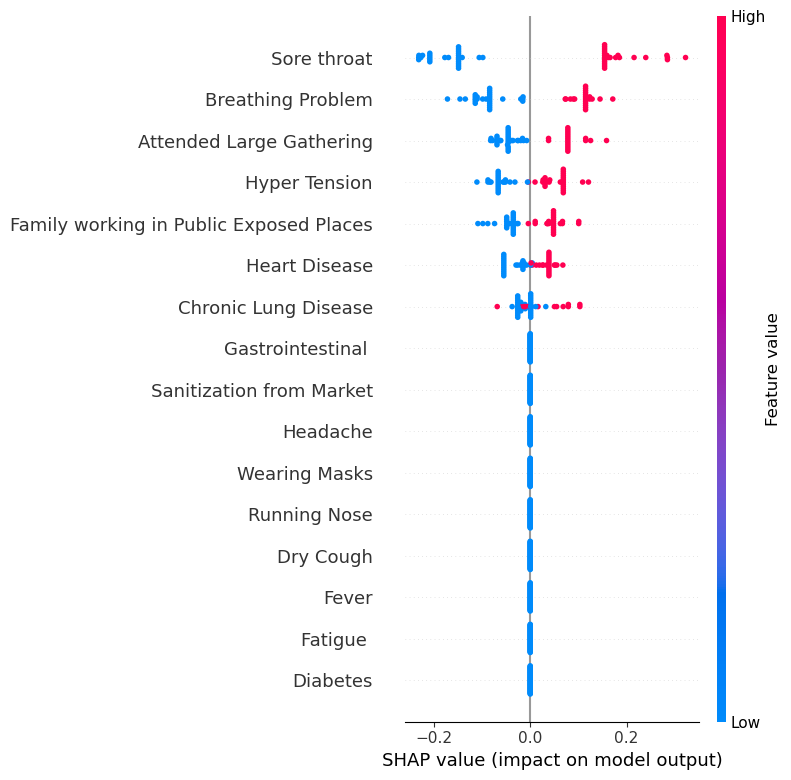

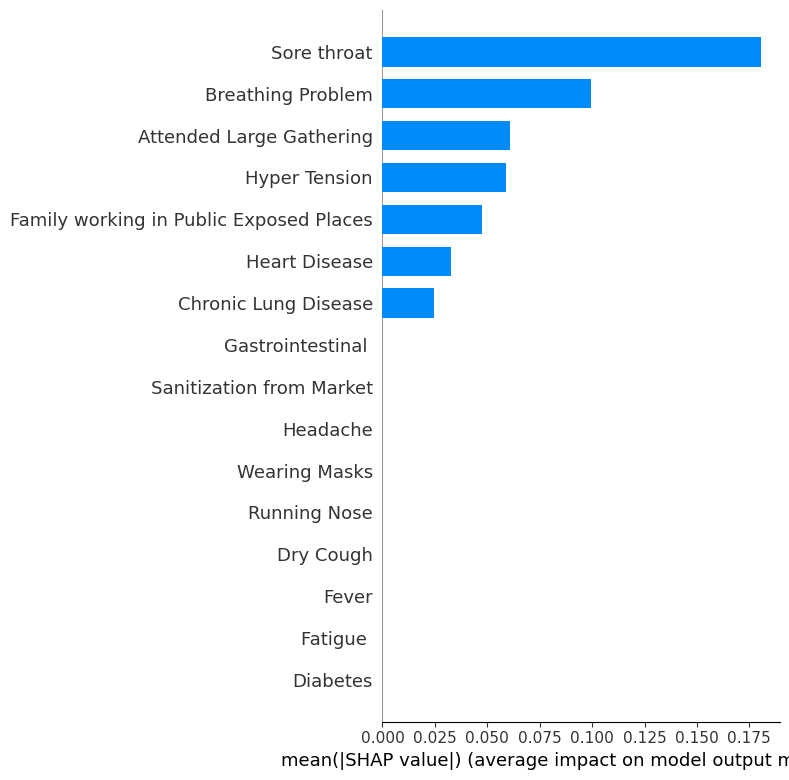

SHAP analysis completed and saved as 'ensemble_shap_summary.png' and 'ensemble_shap_importance.png'
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
LIME explanation for the first instance saved as 'lime_explanation_sample_0.png'


<Figure size 1000x600 with 0 Axes>

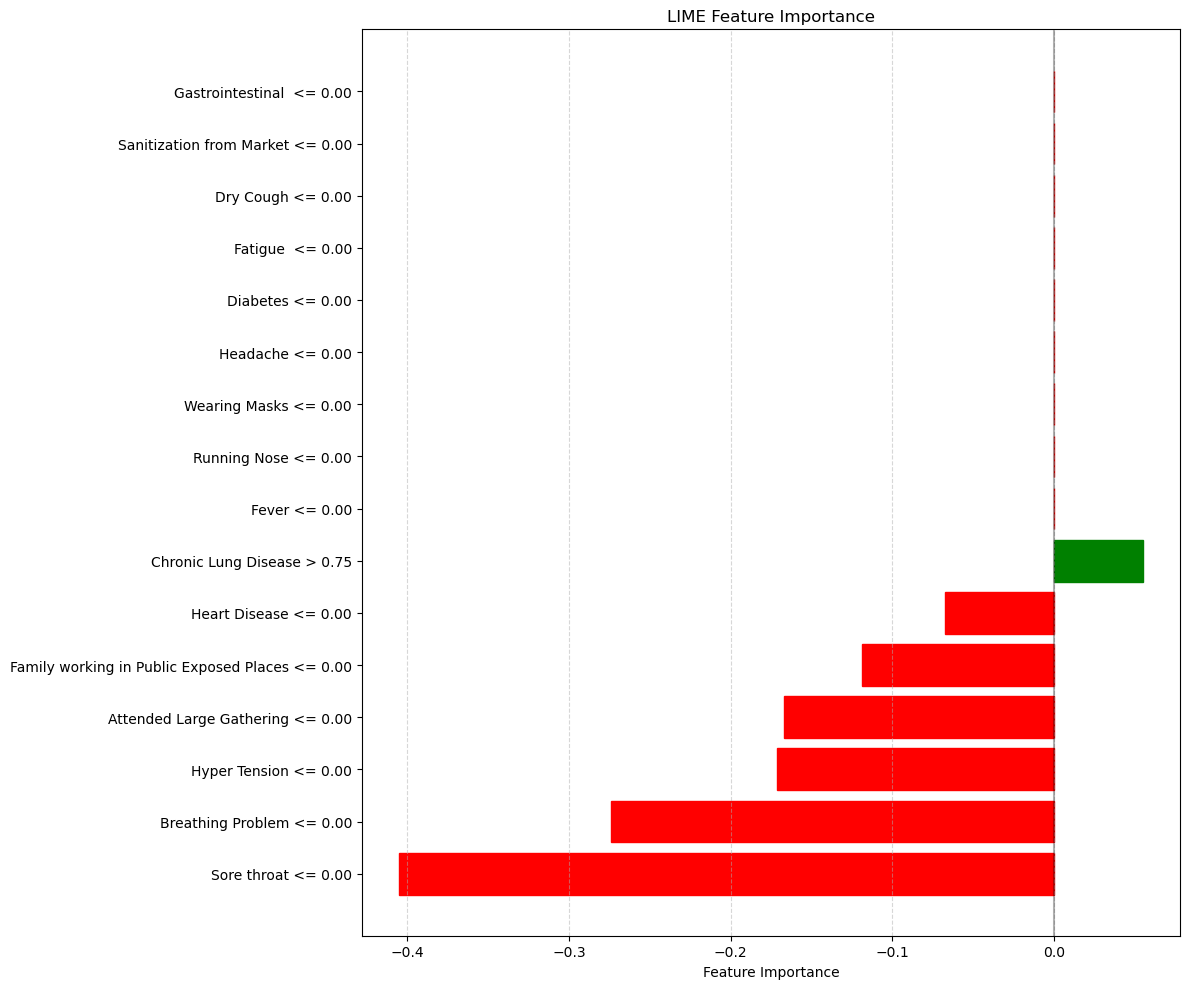

LIME feature importance saved as 'lime_feature_importance.png'
Ensemble model predictions and explanations completed.


In [67]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular
from sklearn.metrics import accuracy_score

# Load the sampled test dataset
df = pd.read_csv("sampled_dataset.csv")
print(f"Shape of the dataset: {df.shape}")

# Ensure binary features are correctly set to 0 or 1
df['Chronic Lung Disease'] = df['Chronic Lung Disease'].clip(lower=0, upper=1)

# Define feature sets for each model
ann_features = ['Breathing Problem', 'Sore throat', 'Running Nose', 'Chronic Lung Disease',
                'Headache', 'Heart Disease', 'Diabetes', 'Hyper Tension', 'Attended Large Gathering', 'Gastrointestinal ']
cnn_features = ['Sore throat', 'Breathing Problem', 'Attended Large Gathering', 
                'Family working in Public Exposed Places', 'Heart Disease', 
                'Hyper Tension', 'Chronic Lung Disease', 'Fever', 
                'Dry Cough', 'Running Nose']
lstm_features = ['Breathing Problem', 'Sore throat', 'Running Nose', 
                 'Chronic Lung Disease', 'Heart Disease', 'Hyper Tension', 
                 'Fatigue ', 'Gastrointestinal ', 'Attended Large Gathering', 
                 'Family working in Public Exposed Places']
mlp_features = ['Breathing Problem', 'Sore throat', 'Chronic Lung Disease',
                'Heart Disease', 'Diabetes', 'Hyper Tension', 'Attended Large Gathering',
                'Family working in Public Exposed Places', 'Wearing Masks', 'Sanitization from Market']
bigru_features = ['Breathing Problem', 'Sore throat', 'Running Nose', 'Chronic Lung Disease',
                  'Headache', 'Heart Disease', 'Diabetes', 'Gastrointestinal ',
                  'Attended Large Gathering', 'Family working in Public Exposed Places']

# All unique features across models
all_features = list(set(ann_features + cnn_features + lstm_features + mlp_features + bigru_features))

# Extract required feature subsets
X_ann = df[ann_features].values
X_cnn = df[cnn_features].values
X_lstm = df[lstm_features].values
X_mlp = df[mlp_features].values
X_bigru = df[bigru_features].values
X_all = df[all_features].values

# Load the pre-trained models
ann_model = tf.keras.models.load_model("covid_ann_results/final_model_ANN.h5")
cnn_model = tf.keras.models.load_model("covid_cnn_results/final_model_CNN.h5")
lstm_model = tf.keras.models.load_model("covid_lstm_results/final_model_lstm.h5")
mlp_model = tf.keras.models.load_model("covid_mlp_results/final_model_mlp.h5")
bigru_model = tf.keras.models.load_model("covid_bigru_results/final_model_BiGRU.h5")

# Print model input shapes to check expected shapes
print(f"ANN model input shape: {ann_model.input_shape}")
print(f"CNN model input shape: {cnn_model.input_shape}")
print(f"LSTM model input shape: {lstm_model.input_shape}")
print(f"MLP model input shape: {mlp_model.input_shape}")
print(f"BiGRU model input shape: {bigru_model.input_shape}")

# Create wrapper functions for each model with corrected shapes
def ann_predict(x):
    input_shape = ann_model.input_shape
    dims = [d if d is not None else x.shape[0] for d in input_shape]
    
    if len(dims) == 4:
        x_reshaped = x.reshape(x.shape[0], dims[1], dims[2], dims[3])
    elif len(dims) == 3:
        x_reshaped = x.reshape(x.shape[0], dims[1], dims[2])
    else:
        x_reshaped = x
        
    preds = ann_model.predict(x_reshaped)
    return preds

def cnn_predict(x):
    input_shape = cnn_model.input_shape
    dims = [d if d is not None else x.shape[0] for d in input_shape]
    
    if len(dims) == 4:
        x_reshaped = x.reshape(x.shape[0], dims[1], dims[2], dims[3])
    else:
        raise ValueError(f"Unexpected CNN input shape: {input_shape}")
        
    preds = cnn_model.predict(x_reshaped)
    return preds

def lstm_predict(x):
    input_shape = lstm_model.input_shape
    dims = [d if d is not None else x.shape[0] for d in input_shape]
    
    if len(dims) == 3:
        x_reshaped = x.reshape(x.shape[0], dims[1], dims[2])
    else:
        raise ValueError(f"Unexpected LSTM input shape: {input_shape}")
        
    preds = lstm_model.predict(x_reshaped)
    return preds

def mlp_predict(x):
    preds = mlp_model.predict(x)
    return preds

def bigru_predict(x):
    input_shape = bigru_model.input_shape
    dims = [d if d is not None else x.shape[0] for d in input_shape]
    
    if len(dims) == 3:
        x_reshaped = x.reshape(x.shape[0], dims[1], dims[2])
    else:
        raise ValueError(f"Unexpected BiGRU input shape: {input_shape}")
        
    preds = bigru_model.predict(x_reshaped)
    return preds

# Modified Ensemble prediction function with dynamic shape handling
def ensemble_predict(x):
    ann_indices = [all_features.index(feature) for feature in ann_features]
    cnn_indices = [all_features.index(feature) for feature in cnn_features]
    lstm_indices = [all_features.index(feature) for feature in lstm_features]
    mlp_indices = [all_features.index(feature) for feature in mlp_features]
    bigru_indices = [all_features.index(feature) for feature in bigru_features]
    
    x_ann = x[:, ann_indices]
    x_cnn = x[:, cnn_indices]
    x_lstm = x[:, lstm_indices]
    x_mlp = x[:, mlp_indices]
    x_bigru = x[:, bigru_indices]
    
    ann_input_shape = ann_model.input_shape
    cnn_input_shape = cnn_model.input_shape
    lstm_input_shape = lstm_model.input_shape
    bigru_input_shape = bigru_model.input_shape
    
    # Reshape inputs according to model requirements
    if len(ann_input_shape) == 4:
        x_ann_reshaped = x_ann.reshape(x_ann.shape[0], 
                                      ann_input_shape[1] or 1, 
                                      ann_input_shape[2] or 1, 
                                      ann_input_shape[3] or 1)
    elif len(ann_input_shape) == 3:
        x_ann_reshaped = x_ann.reshape(x_ann.shape[0], 
                                      ann_input_shape[1] or x_ann.shape[0], 
                                      ann_input_shape[2] or 1)
    else:
        x_ann_reshaped = x_ann
    
    if len(cnn_input_shape) == 4:
        x_cnn_reshaped = x_cnn.reshape(x_cnn.shape[0], 
                                      cnn_input_shape[1] or 2, 
                                      cnn_input_shape[2] or 5, 
                                      cnn_input_shape[3] or 1)
    else:
        x_cnn_reshaped = x_cnn
    
    if len(lstm_input_shape) == 3:
        x_lstm_reshaped = x_lstm.reshape(x_lstm.shape[0], 
                                        lstm_input_shape[1] or 10, 
                                        lstm_input_shape[2] or 1)
    else:
        x_lstm_reshaped = x_lstm
    
    if len(bigru_input_shape) == 3:
        x_bigru_reshaped = x_bigru.reshape(x_bigru.shape[0], 
                                          bigru_input_shape[1] or 10, 
                                          bigru_input_shape[2] or 1)
    else:
        x_bigru_reshaped = x_bigru
    
    # Get probabilities from each model
    try:
        ann_prob = ann_model.predict(x_ann_reshaped)
        cnn_prob = cnn_model.predict(x_cnn_reshaped)
        lstm_prob = lstm_model.predict(x_lstm_reshaped)
        mlp_prob = mlp_model.predict(x_mlp)
        bigru_prob = bigru_model.predict(x_bigru_reshaped)
        
        # Average the probabilities for soft voting
        ensemble_prob = (ann_prob + cnn_prob + lstm_prob + mlp_prob + bigru_prob) / 5
        
        if len(ensemble_prob.shape) == 1 or ensemble_prob.shape[1] == 1:
            return np.hstack((1 - ensemble_prob, ensemble_prob))
        else:
            return ensemble_prob
    except Exception as e:
        print(f"Error in ensemble prediction: {e}")
        print(f"ANN input shape: {x_ann_reshaped.shape}, Model expects: {ann_input_shape}")
        print(f"CNN input shape: {x_cnn_reshaped.shape}, Model expects: {cnn_input_shape}")
        print(f"LSTM input shape: {x_lstm_reshaped.shape}, Model expects: {lstm_input_shape}")
        print(f"MLP input shape: {x_mlp.shape}, Model expects: {mlp_model.input_shape}")
        print(f"BiGRU input shape: {x_bigru_reshaped.shape}, Model expects: {bigru_input_shape}")
        raise

# Function to get final predictions (class labels)
def get_ensemble_predictions(x):
    probs = ensemble_predict(x)
    return np.argmax(probs, axis=1)

# Modified SHAP function to display and save the visualization
def explain_with_shap(X_sample, feature_names, num_samples=100):
    def model_prob_wrapper(x):
        probs = ensemble_predict(x)
        return probs[:, 1]  # Return probability of positive class
        
    background_data = X_sample[np.random.choice(X_sample.shape[0], min(100, X_sample.shape[0]), replace=False)]
    explainer = shap.KernelExplainer(model_prob_wrapper, background_data)
    explanation_samples = X_sample[:num_samples]
    shap_values = explainer.shap_values(explanation_samples)
    
    # Create and display SHAP summary plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, explanation_samples, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig("ensemble_shap_summary.png", dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot
    
    # Create and display SHAP bar plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, explanation_samples, feature_names=feature_names, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig("ensemble_shap_importance.png", dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot
    
    print("SHAP analysis completed and saved as 'ensemble_shap_summary.png' and 'ensemble_shap_importance.png'")
    
    return shap_values

# Modified LIME function for accurate explanations
def explain_with_lime(X_sample, feature_names, class_names=['Negative', 'Positive'], num_samples=100):
    # Create the LIME explainer with the proper training data
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_sample,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        random_state=42  # Set random state for reproducibility
    )
    
    # Select a representative sample to explain (using a small batch for more robust results)
    sample_to_explain = X_sample[0]  # Only take the first instance
    explanation = explainer.explain_instance(
        sample_to_explain, 
        ensemble_predict,
        num_features=len(feature_names),
        top_labels=2  # For binary classification
    )
    
    # Get the prediction class for this sample
    pred_class = np.argmax(ensemble_predict(sample_to_explain.reshape(1, -1)), axis=1)[0]
    
    # Plot the explanation
    plt.figure(figsize=(10, 6))
    explanation.as_pyplot_figure(label=pred_class)
    plt.title("LIME Instance Level Summary")  # Change title
    plt.tight_layout()
    plt.savefig("lime_explanation_sample_0.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    print("LIME explanation for the first instance saved as 'lime_explanation_sample_0.png'")
    
    # Feature importance aggregation for LIME
    feature_importance = explanation.as_list()
    features, weights = zip(*feature_importance)
    
    # Create a horizontal bar chart for LIME feature importance
    plt.figure(figsize=(12, 10))
    y_pos = np.arange(len(features))
    bars = plt.barh(y_pos, weights, align='center')
    
    # Color positive and negative contributions differently
    for i, w in enumerate(weights):
        bars[i].set_color('green' if w > 0 else 'red')
    
    # Set y-axis labels and other chart properties
    plt.yticks(y_pos, features)
    plt.xlabel('Feature Importance')
    plt.title('LIME Feature Importance')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # Save and display the plot
    plt.savefig("lime_feature_importance.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("LIME feature importance saved as 'lime_feature_importance.png'")
    
    return explanation

# Example usage of the ensemble prediction and explanation functions
if __name__ == "__main__":
    # First check and print the actual shapes from the loaded models
    print("\nChecking actual model input shapes:")
    print(f"ANN model input shape: {ann_model.input_shape}")
    print(f"CNN model input shape: {cnn_model.input_shape}")
    print(f"LSTM model input shape: {lstm_model.input_shape}")
    print(f"MLP model input shape: {mlp_model.input_shape}")
    print(f"BiGRU model input shape: {bigru_model.input_shape}")

    # Make predictions using the ensemble model
    try:
        ensemble_predictions = get_ensemble_predictions(X_all)
        print(f"Ensemble predictions shape: {ensemble_predictions.shape}")
        print(f"Ensemble predictions: {ensemble_predictions[:]}")
        
        # Explain the ensemble model using SHAP
        explain_with_shap(X_all, all_features)

        # Explain the ensemble model using LIME
        explain_with_lime(X_all, all_features)
        
        print("Ensemble model predictions and explanations completed.")
    except Exception as e:
        print(f"Error during execution: {e}")

In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular
from sklearn.metrics import accuracy_score

# Load the sampled test dataset
df = pd.read_csv("sampled_dataset.csv")
print(f"Shape of the dataset: {df.shape}")

# Define feature sets for each model
ann_features = ['Breathing Problem', 'Sore throat', 'Running Nose', 'Chronic Lung Disease',
                'Headache', 'Heart Disease', 'Diabetes', 'Hyper Tension', 'Attended Large Gathering', 'Gastrointestinal ']
cnn_features = ['Sore throat', 'Breathing Problem', 'Attended Large Gathering', 
                'Family working in Public Exposed Places', 'Heart Disease', 
                'Hyper Tension', 'Chronic Lung Disease', 'Fever', 
                'Dry Cough', 'Running Nose']
lstm_features = ['Breathing Problem', 'Sore throat', 'Running Nose', 
                 'Chronic Lung Disease', 'Heart Disease', 'Hyper Tension', 
                 'Fatigue ', 'Gastrointestinal ', 'Attended Large Gathering', 
                 'Family working in Public Exposed Places']
mlp_features = ['Breathing Problem', 'Sore throat', 'Chronic Lung Disease',
                'Heart Disease', 'Diabetes', 'Hyper Tension', 'Attended Large Gathering',
                'Family working in Public Exposed Places', 'Wearing Masks', 'Sanitization from Market']
bigru_features = ['Breathing Problem', 'Sore throat', 'Running Nose', 'Chronic Lung Disease',
                  'Headache', 'Heart Disease', 'Diabetes', 'Gastrointestinal ',
                  'Attended Large Gathering', 'Family working in Public Exposed Places']

# All unique features across models
all_features = list(set(ann_features + cnn_features + lstm_features + mlp_features + bigru_features))

# Extract required feature subsets
X_ann = df[ann_features].values
X_cnn = df[cnn_features].values
X_lstm = df[lstm_features].values
X_mlp = df[mlp_features].values
X_bigru = df[bigru_features].values
X_all = df[all_features].values

# Load the pre-trained models
ann_model = tf.keras.models.load_model("covid_ann_results/final_model_ANN.h5")
cnn_model = tf.keras.models.load_model("covid_cnn_results/final_model_CNN.h5")
lstm_model = tf.keras.models.load_model("covid_lstm_results/final_model_lstm.h5")
mlp_model = tf.keras.models.load_model("covid_mlp_results/final_model_mlp.h5")
bigru_model = tf.keras.models.load_model("covid_bigru_results/final_model_BiGRU.h5")

# Print model input shapes to check expected shapes
print(f"ANN model input shape: {ann_model.input_shape}")
print(f"CNN model input shape: {cnn_model.input_shape}")
print(f"LSTM model input shape: {lstm_model.input_shape}")
print(f"MLP model input shape: {mlp_model.input_shape}")
print(f"BiGRU model input shape: {bigru_model.input_shape}")

# Create wrapper functions for each model with corrected shapes
def ann_predict(x):
    # Dynamically determine the reshape based on the model's input shape
    input_shape = ann_model.input_shape
    # Remove None (batch dimension) from input_shape
    dims = [d if d is not None else x.shape[0] for d in input_shape]
    
    if len(dims) == 4:  # 4D input (batch, height, width, channels)
        x_reshaped = x.reshape(x.shape[0], dims[1], dims[2], dims[3])
    elif len(dims) == 3:  # 3D input (batch, steps, features)
        x_reshaped = x.reshape(x.shape[0], dims[1], dims[2])
    else:  # 2D input (batch, features)
        x_reshaped = x
        
    preds = ann_model.predict(x_reshaped)
    return preds

def cnn_predict(x):
    # Dynamically determine the reshape based on the model's input shape
    input_shape = cnn_model.input_shape
    # Remove None (batch dimension) from input_shape
    dims = [d if d is not None else x.shape[0] for d in input_shape]
    
    if len(dims) == 4:  # 4D input (batch, height, width, channels)
        x_reshaped = x.reshape(x.shape[0], dims[1], dims[2], dims[3])
    else:
        raise ValueError(f"Unexpected CNN input shape: {input_shape}")
        
    preds = cnn_model.predict(x_reshaped)
    return preds

def lstm_predict(x):
    # Dynamically determine the reshape based on the model's input shape
    input_shape = lstm_model.input_shape
    # Remove None (batch dimension) from input_shape
    dims = [d if d is not None else x.shape[0] for d in input_shape]
    
    if len(dims) == 3:  # 3D input (batch, steps, features)
        x_reshaped = x.reshape(x.shape[0], dims[1], dims[2])
    else:
        raise ValueError(f"Unexpected LSTM input shape: {input_shape}")
        
    preds = lstm_model.predict(x_reshaped)
    return preds

def mlp_predict(x):
    # MLP typically doesn't need reshaping (just flat input)
    preds = mlp_model.predict(x)
    return preds

def bigru_predict(x):
    # Dynamically determine the reshape based on the model's input shape
    input_shape = bigru_model.input_shape
    # Remove None (batch dimension) from input_shape
    dims = [d if d is not None else x.shape[0] for d in input_shape]
    
    if len(dims) == 3:  # 3D input (batch, steps, features)
        x_reshaped = x.reshape(x.shape[0], dims[1], dims[2])
    else:
        raise ValueError(f"Unexpected BiGRU input shape: {input_shape}")
        
    preds = bigru_model.predict(x_reshaped)
    return preds

# Modified Ensemble prediction function with dynamic shape handling
def ensemble_predict(x):
    # Extract features for each model using the correct indices
    ann_indices = [all_features.index(feature) for feature in ann_features]
    cnn_indices = [all_features.index(feature) for feature in cnn_features]
    lstm_indices = [all_features.index(feature) for feature in lstm_features]
    mlp_indices = [all_features.index(feature) for feature in mlp_features]
    bigru_indices = [all_features.index(feature) for feature in bigru_features]
    
    x_ann = x[:, ann_indices]
    x_cnn = x[:, cnn_indices]
    x_lstm = x[:, lstm_indices]
    x_mlp = x[:, mlp_indices]
    x_bigru = x[:, bigru_indices]
    
    # Get model input shapes
    ann_input_shape = ann_model.input_shape
    cnn_input_shape = cnn_model.input_shape
    lstm_input_shape = lstm_model.input_shape
    bigru_input_shape = bigru_model.input_shape
    
    # Reshape inputs according to model requirements
    # ANN reshape
    if len(ann_input_shape) == 4:  # 4D input
        x_ann_reshaped = x_ann.reshape(x_ann.shape[0], 
                                      ann_input_shape[1] or 1, 
                                      ann_input_shape[2] or 1, 
                                      ann_input_shape[3] or 1)
    elif len(ann_input_shape) == 3:  # 3D input
        x_ann_reshaped = x_ann.reshape(x_ann.shape[0], 
                                      ann_input_shape[1] or x_ann.shape[0], 
                                      ann_input_shape[2] or 1)
    else:  # 2D input
        x_ann_reshaped = x_ann
    
    # CNN reshape
    if len(cnn_input_shape) == 4:  # 4D input
        x_cnn_reshaped = x_cnn.reshape(x_cnn.shape[0], 
                                      cnn_input_shape[1] or 2, 
                                      cnn_input_shape[2] or 5, 
                                      cnn_input_shape[3] or 1)
    else:
        x_cnn_reshaped = x_cnn
    
    # LSTM reshape
    if len(lstm_input_shape) == 3:  # 3D input
        x_lstm_reshaped = x_lstm.reshape(x_lstm.shape[0], 
                                        lstm_input_shape[1] or 10, 
                                        lstm_input_shape[2] or 1)
    else:
        x_lstm_reshaped = x_lstm
    
    # BiGRU reshape
    if len(bigru_input_shape) == 3:  # 3D input
        x_bigru_reshaped = x_bigru.reshape(x_bigru.shape[0], 
                                          bigru_input_shape[1] or 10, 
                                          bigru_input_shape[2] or 1)
    else:
        x_bigru_reshaped = x_bigru
    
    # Get probabilities from each model
    try:
        ann_prob = ann_model.predict(x_ann_reshaped)
        cnn_prob = cnn_model.predict(x_cnn_reshaped)
        lstm_prob = lstm_model.predict(x_lstm_reshaped)
        mlp_prob = mlp_model.predict(x_mlp)
        bigru_prob = bigru_model.predict(x_bigru_reshaped)
        
        # Average the probabilities for soft voting (now with 5 models)
        ensemble_prob = (ann_prob + cnn_prob + lstm_prob + mlp_prob + bigru_prob) / 5
        
        # Return class probabilities for SHAP/LIME compatibility
        if len(ensemble_prob.shape) == 1 or ensemble_prob.shape[1] == 1:
            # Handle binary classification case
            return np.hstack((1 - ensemble_prob, ensemble_prob))
        else:
            # Return probabilities for multi-class
            return ensemble_prob
    except Exception as e:
        print(f"Error in ensemble prediction: {e}")
        # Print debug information
        print(f"ANN input shape: {x_ann_reshaped.shape}, Model expects: {ann_input_shape}")
        print(f"CNN input shape: {x_cnn_reshaped.shape}, Model expects: {cnn_input_shape}")
        print(f"LSTM input shape: {x_lstm_reshaped.shape}, Model expects: {lstm_input_shape}")
        print(f"MLP input shape: {x_mlp.shape}, Model expects: {mlp_model.input_shape}")
        print(f"BiGRU input shape: {x_bigru_reshaped.shape}, Model expects: {bigru_input_shape}")
        raise

# Function to get final predictions (class labels)
def get_ensemble_predictions(x):
    probs = ensemble_predict(x)
    return np.argmax(probs, axis=1)

# Modified SHAP function to display and save the visualization
def explain_with_shap(X_sample, feature_names, num_samples=100):
    def model_prob_wrapper(x):
        probs = ensemble_predict(x)
        return probs[:, 1]  # Return probability of positive class
        
    background_data = X_sample[np.random.choice(X_sample.shape[0], min(100, X_sample.shape[0]), replace=False)]
    explainer = shap.KernelExplainer(model_prob_wrapper, background_data)
    explanation_samples = X_sample[:num_samples]
    shap_values = explainer.shap_values(explanation_samples)
    
    # Create and display SHAP summary plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, explanation_samples, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig("ensemble_shap_summary.png", dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot
    
    # Create and display SHAP bar plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, explanation_samples, feature_names=feature_names, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig("ensemble_shap_importance.png", dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot
    
    print("SHAP analysis completed and saved as 'ensemble_shap_summary.png' and 'ensemble_shap_importance.png'")
    
    return shap_values

# Completely rewritten LIME function to ensure it works correctly
def explain_with_lime(X_sample, feature_names, class_names=['Negative', 'Positive']):
    # Create a simplified wrapper function for the ensemble model
    def predict_fn(x):
        return ensemble_predict(x)
    
    # Create explainer object
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_sample,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        discretize_continuous=True
    )
    
    # Select a single instance to explain (first instance)
    instance_to_explain = X_sample[0]
    
    # Get explanation for the selected instance
    try:
        exp = explainer.explain_instance(
            instance_to_explain,
            predict_fn,
            num_features=len(feature_names),
            top_labels=1
        )
        
        # Get class prediction for this instance
        pred_class = np.argmax(predict_fn([instance_to_explain])[0])
        class_name = class_names[pred_class]
        
        # Get explanation for this class
        exp_list = exp.as_list(label=pred_class)
        
        # Sort by absolute impact (most important first)
        exp_list = sorted(exp_list, key=lambda x: abs(x[1]), reverse=True)
        
        # Get feature names and weights
        features = [x[0] for x in exp_list]
        weights = [x[1] for x in exp_list]
        
        # Create custom plot
        plt.figure(figsize=(10, 8))
        colors = ['green' if w > 0 else 'red' for w in weights]
        y_pos = np.arange(len(features))
        
        # Create horizontal bar chart
        bars = plt.barh(y_pos, weights, align='center', color=colors)
        plt.yticks(y_pos, features)
        plt.xlabel('Impact on prediction')
        plt.title(f'Feature Importance for Prediction: {class_name}')
        
        # Add a vertical line at x=0
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Add value labels to the bars
        for i, v in enumerate(weights):
            plt.text(v + 0.01 if v > 0 else v - 0.06, 
                     i, 
                     f'{v:.3f}', 
                     va='center', 
                     fontweight='bold',
                     color='black')
        
        plt.tight_layout()
        plt.savefig('lime_explanation.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"LIME explanation saved as 'lime_explanation.png'")
        
        # Generate HTML explanation for additional reference
        exp.save_to_file('lime_explanation.html')
        print(f"LIME HTML explanation saved as 'lime_explanation.html'")
        
    except Exception as e:
        print(f"Error in LIME explanation: {e}")
        # Try with a different approach
        try:
            # Simpler approach with direct feature importance
            print("Attempting alternative LIME approach...")
            
            # Create a prediction function that returns class probabilities
            def predict_proba(x):
                return predict_fn(x)
            
            # Get prediction probabilities for this instance
            probs = predict_proba([instance_to_explain])[0]
            pred_class = np.argmax(probs)
            
            # Generate manual feature importance using correlation
            importance = []
            for i, feature in enumerate(feature_names):
                # Create a copy of the instance
                modified = instance_to_explain.copy()
                # Change the feature value
                original_val = modified[i]
                # Set to 0 (absence) if it was 1, or 1 (presence) if it was 0
                modified[i] = 1 - original_val
                
                # Get new prediction
                new_probs = predict_proba([modified])[0]
                # Impact is the change in probability for the predicted class
                impact = probs[pred_class] - new_probs[pred_class]
                importance.append((feature, impact))
            
            # Sort by absolute impact
            importance.sort(key=lambda x: abs(x[1]), reverse=True)
            
            # Create visualization
            features = [x[0] for x in importance]
            weights = [x[1] for x in importance]
            
            plt.figure(figsize=(10, 8))
            colors = ['green' if w > 0 else 'red' for w in weights]
            y_pos = np.arange(len(features))
            
            plt.barh(y_pos, weights, align='center', color=colors)
            plt.yticks(y_pos, features)
            plt.xlabel('Feature Impact')
            plt.title(f'Manual Feature Importance (Alternative Method)')
            plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('lime_explanation_alt.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print("Alternative LIME visualization saved as 'lime_explanation_alt.png'")
            
        except Exception as e2:
            print(f"Alternative LIME approach also failed: {e2}")

# Example usage of the ensemble prediction and explanation functions
if __name__ == "__main__":
    # First check and print the actual shapes from the loaded models
    print("\nChecking actual model input shapes:")
    print(f"ANN model input shape: {ann_model.input_shape}")
    print(f"CNN model input shape: {cnn_model.input_shape}")
    print(f"LSTM model input shape: {lstm_model.input_shape}")
    print(f"MLP model input shape: {mlp_model.input_shape}")
    print(f"BiGRU model input shape: {bigru_model.input_shape}")
    
    # Make predictions using the ensemble model
    try:
        ensemble_predictions = get_ensemble_predictions(X_all)
        print(f"Ensemble predictions shape: {ensemble_predictions.shape}")
        print(f"First few predictions: {ensemble_predictions[:5]}")
        
        # Explain the ensemble model using SHAP
        explain_with_shap(X_all, all_features, num_samples=50)  # Reduced sample size for faster processing

        # Explain the ensemble model using LIME
        explain_with_lime(X_all, all_features)
        
        print("Ensemble model predictions and explanations completed.")
    except Exception as e:
        print(f"Error during execution: {e}")

Shape of the dataset: (50, 21)


ANN model input shape: (None, 10, 1, 1)
CNN model input shape: (None, 2, 5, 1)
LSTM model input shape: (None, 10, 1)
MLP model input shape: (None, 10)
BiGRU model input shape: (None, 10, 1)

Checking actual model input shapes:
ANN model input shape: (None, 10, 1, 1)
CNN model input shape: (None, 2, 5, 1)
LSTM model input shape: (None, 10, 1)
MLP model input shape: (None, 10)
BiGRU model input shape: (None, 10, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 915ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Ensemble predictions shape: (50,)
First few predictions: [0 1 1 0 0]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 35/197 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular
from sklearn.metrics import accuracy_score

# Load the sampled test dataset
df = pd.read_csv("sampled_dataset.csv")
print(f"Shape of the dataset: {df.shape}")

# Define feature sets for each model
ann_features = ['Breathing Problem', 'Sore throat', 'Running Nose', 'Chronic Lung Disease',
                'Headache', 'Heart Disease', 'Diabetes', 'Hyper Tension', 'Attended Large Gathering', 'Gastrointestinal ']
cnn_features = ['Sore throat', 'Breathing Problem', 'Attended Large Gathering', 
                'Family working in Public Exposed Places', 'Heart Disease', 
                'Hyper Tension', 'Chronic Lung Disease', 'Fever', 
                'Dry Cough', 'Running Nose']
lstm_features = ['Breathing Problem', 'Sore throat', 'Running Nose', 
                 'Chronic Lung Disease', 'Heart Disease', 'Hyper Tension', 
                 'Fatigue ', 'Gastrointestinal ', 'Attended Large Gathering', 
                 'Family working in Public Exposed Places']
mlp_features = ['Breathing Problem', 'Sore throat', 'Chronic Lung Disease',
                'Heart Disease', 'Diabetes', 'Hyper Tension', 'Attended Large Gathering',
                'Family working in Public Exposed Places', 'Wearing Masks', 'Sanitization from Market']
bigru_features = ['Breathing Problem', 'Sore throat', 'Running Nose', 'Chronic Lung Disease',
                  'Headache', 'Heart Disease', 'Diabetes', 'Gastrointestinal ',
                  'Attended Large Gathering', 'Family working in Public Exposed Places']

# All unique features across models
all_features = list(set(ann_features + cnn_features + lstm_features + mlp_features + bigru_features))

# Extract required feature subsets
X_ann = df[ann_features].values
X_cnn = df[cnn_features].values
X_lstm = df[lstm_features].values
X_mlp = df[mlp_features].values
X_bigru = df[bigru_features].values
X_all = df[all_features].values

# Load the pre-trained models
ann_model = tf.keras.models.load_model("covid_ann_results/final_model_ANN.h5")
cnn_model = tf.keras.models.load_model("covid_cnn_results/final_model_CNN.h5")
lstm_model = tf.keras.models.load_model("covid_lstm_results/final_model_lstm.h5")
mlp_model = tf.keras.models.load_model("covid_mlp_results/final_model_mlp.h5")
bigru_model = tf.keras.models.load_model("covid_bigru_results/final_model_BiGRU.h5")

# Print model input shapes to check expected shapes
print(f"ANN model input shape: {ann_model.input_shape}")
print(f"CNN model input shape: {cnn_model.input_shape}")
print(f"LSTM model input shape: {lstm_model.input_shape}")
print(f"MLP model input shape: {mlp_model.input_shape}")
print(f"BiGRU model input shape: {bigru_model.input_shape}")

# Create wrapper functions for each model with corrected shapes
def ann_predict(x):
    input_shape = ann_model.input_shape
    dims = [d if d is not None else x.shape[0] for d in input_shape]
    
    if len(dims) == 4:
        x_reshaped = x.reshape(x.shape[0], dims[1], dims[2], dims[3])
    elif len(dims) == 3:
        x_reshaped = x.reshape(x.shape[0], dims[1], dims[2])
    else:
        x_reshaped = x
        
    preds = ann_model.predict(x_reshaped)
    return preds

def cnn_predict(x):
    input_shape = cnn_model.input_shape
    dims = [d if d is not None else x.shape[0] for d in input_shape]
    
    if len(dims) == 4:
        x_reshaped = x.reshape(x.shape[0], dims[1], dims[2], dims[3])
    else:
        raise ValueError(f"Unexpected CNN input shape: {input_shape}")
        
    preds = cnn_model.predict(x_reshaped)
    return preds

def lstm_predict(x):
    input_shape = lstm_model.input_shape
    dims = [d if d is not None else x.shape[0] for d in input_shape]
    
    if len(dims) == 3:
        x_reshaped = x.reshape(x.shape[0], dims[1], dims[2])
    else:
        raise ValueError(f"Unexpected LSTM input shape: {input_shape}")
        
    preds = lstm_model.predict(x_reshaped)
    return preds

def mlp_predict(x):
    # MLP typically doesn't need reshaping (just flat input)
    preds = mlp_model.predict(x)
    return preds

def bigru_predict(x):
    input_shape = bigru_model.input_shape
    dims = [d if d is not None else x.shape[0] for d in input_shape]
    
    if len(dims) == 3:
        x_reshaped = x.reshape(x.shape[0], dims[1], dims[2])
    else:
        raise ValueError(f"Unexpected BiGRU input shape: {input_shape}")
        
    preds = bigru_model.predict(x_reshaped)
    return preds

# Modified Ensemble prediction function with dynamic shape handling
def ensemble_predict(x):
    # Extract features for each model using the correct indices
    ann_indices = [all_features.index(feature) for feature in ann_features]
    cnn_indices = [all_features.index(feature) for feature in cnn_features]
    lstm_indices = [all_features.index(feature) for feature in lstm_features]
    mlp_indices = [all_features.index(feature) for feature in mlp_features]
    bigru_indices = [all_features.index(feature) for feature in bigru_features]
    
    x_ann = x[:, ann_indices]
    x_cnn = x[:, cnn_indices]
    x_lstm = x[:, lstm_indices]
    x_mlp = x[:, mlp_indices]
    x_bigru = x[:, bigru_indices]
    
    # Get model input shapes
    ann_input_shape = ann_model.input_shape
    cnn_input_shape = cnn_model.input_shape
    lstm_input_shape = lstm_model.input_shape
    bigru_input_shape = bigru_model.input_shape
    
    # Reshape inputs according to model requirements
    # ANN reshape
    if len(ann_input_shape) == 4:  # 4D input
        x_ann_reshaped = x_ann.reshape(x_ann.shape[0], 
                                      ann_input_shape[1] or 1, 
                                      ann_input_shape[2] or 1, 
                                      ann_input_shape[3] or 1)
    elif len(ann_input_shape) == 3:  # 3D input
        x_ann_reshaped = x_ann.reshape(x_ann.shape[0], 
                                      ann_input_shape[1] or x_ann.shape[0], 
                                      ann_input_shape[2] or 1)
    else:  # 2D input
        x_ann_reshaped = x_ann
    
    # CNN reshape
    if len(cnn_input_shape) == 4:  # 4D input
        x_cnn_reshaped = x_cnn.reshape(x_cnn.shape[0], 
                                      cnn_input_shape[1] or 2, 
                                      cnn_input_shape[2] or 5, 
                                      cnn_input_shape[3] or 1)
    else:
        x_cnn_reshaped = x_cnn
    
    # LSTM reshape
    if len(lstm_input_shape) == 3:  # 3D input
        x_lstm_reshaped = x_lstm.reshape(x_lstm.shape[0], 
                                        lstm_input_shape[1] or 10, 
                                        lstm_input_shape[2] or 1)
    else:
        x_lstm_reshaped = x_lstm
    
    # MLP does not need reshaping
    x_mlp_reshaped = x_mlp  # MLP input is already in the correct shape
    
    # BiGRU reshape
    if len(bigru_input_shape) == 3:  # 3D input
        x_bigru_reshaped = x_bigru.reshape(x_bigru.shape[0], 
                                          bigru_input_shape[1] or 10, 
                                          bigru_input_shape[2] or 1)
    else:
        x_bigru_reshaped = x_bigru
    
    # Get probabilities from each model
    try:
        ann_prob = ann_model.predict(x_ann_reshaped)
        cnn_prob = cnn_model.predict(x_cnn_reshaped)
        lstm_prob = lstm_model.predict(x_lstm_reshaped)
        mlp_prob = mlp_model.predict(x_mlp_reshaped)  # No reshaping needed for MLP
        bigru_prob = bigru_model.predict(x_bigru_reshaped)
        
        # Average the probabilities for soft voting (now with 5 models)
        ensemble_prob = (ann_prob + cnn_prob + lstm_prob + mlp_prob + bigru_prob) / 5
        
        # Return class probabilities for SHAP/LIME compatibility
        if len(ensemble_prob.shape) == 1 or ensemble_prob.shape[1] == 1:
            # Handle binary classification case
            return np.hstack((1 - ensemble_prob, ensemble_prob))
        else:
            # Return probabilities for multi-class
            return ensemble_prob
    except Exception as e:
        print(f"Error in ensemble prediction: {e}")
        # Print debug information
        print(f"ANN input shape: {x_ann_reshaped.shape}, Model expects: {ann_input_shape}")
        print(f"CNN input shape: {x_cnn_reshaped.shape}, Model expects: {cnn_input_shape}")
        print(f"LSTM input shape: {x_lstm_reshaped.shape}, Model expects: {lstm_input_shape}")
        print(f"MLP input shape: {x_mlp_reshaped.shape}, Model expects: {mlp_model.input_shape}")
        print(f"BiGRU input shape: {x_bigru_reshaped.shape}, Model expects: {bigru_input_shape}")
        raise

# Function to get final predictions (class labels)
def get_ensemble_predictions(x):
    probs = ensemble_predict(x)
    return np.argmax(probs, axis=1)

# Modified SHAP function to display and save the visualization
def explain_with_shap(X_sample, feature_names, num_samples=100):
    def model_prob_wrapper(x):
        probs = ensemble_predict(x)
        return probs[:, 1]  # Return probability of positive class
        
    background_data = X_sample[np.random.choice(X_sample.shape[0], min(100, X_sample.shape[0]), replace=False)]
    explainer = shap.KernelExplainer(model_prob_wrapper, background_data)
    explanation_samples = X_sample[:num_samples]
    shap_values = explainer.shap_values(explanation_samples)
    
    # Create and display SHAP summary plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, explanation_samples, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig("ensemble_shap_summary.png", dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot
    
    # Create and display SHAP bar plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, explanation_samples, feature_names=feature_names, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig("ensemble_shap_importance.png", dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot
    
    print("SHAP analysis completed and saved as 'ensemble_shap_summary.png' and 'ensemble_shap_importance.png'")
    
    return shap_values

# Modified LIME function for accurate explanations for a single instance
def explain_with_lime_single_instance(X_sample, feature_names, instance_index, class_names=['Negative', 'Positive']):
    # Create the LIME explainer with the proper training data
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_sample,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        random_state=42  # Set random state for reproducibility
    )
    
    # Get the specific instance to explain
    sample = X_sample[instance_index]
    
    # Get explanation for this instance
    explanation = explainer.explain_instance(
        sample, 
        ensemble_predict,
        num_features=len(feature_names),
        top_labels=2  # For binary classification
    )
    
    # Get the prediction class for this sample
    pred_class = np.argmax(ensemble_predict(sample.reshape(1, -1)), axis=1)[0]
    
    # Plot the explanation
    plt.figure(figsize=(10, 6))
    explanation.as_pyplot_figure(label=pred_class)
    plt.tight_layout()
    plt.savefig(f"lime_explanation_instance_{instance_index}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"LIME explanation for instance {instance_index} saved as 'lime_explanation_instance_{instance_index}.png'")

# Example usage of the ensemble prediction and explanation functions
if __name__ == "__main__":
    # First check and print the actual shapes from the loaded models
    print("\nChecking actual model input shapes:")
    print(f"ANN model input shape: {ann_model.input_shape}")
    print(f"CNN model input shape: {cnn_model.input_shape}")
    print(f"LSTM model input shape: {lstm_model.input_shape}")
    print(f"MLP model input shape: {mlp_model.input_shape}")
    print(f"BiGRU model input shape: {bigru_model.input_shape}")
    
    # Make predictions using the ensemble model
    try:
        ensemble_predictions = get_ensemble_predictions(X_all)
        print(f"Ensemble predictions shape: {ensemble_predictions.shape}")
        print(f"Ensemble predictions: {ensemble_predictions[:]}")
        
        # Explain the ensemble model using SHAP
        explain_with_shap(X_all, all_features)

        # Explain a specific instance using LIME
        instance_index = 0  # Change this index to explain a different instance
        explain_with_lime_single_instance(X_all, all_features, instance_index)
        
        print("Ensemble model predictions and explanations completed.")
    except Exception as e:
        print(f"Error during execution: {e}")

Shape of the dataset: (50, 21)


ANN model input shape: (None, 10, 1, 1)
CNN model input shape: (None, 2, 5, 1)
LSTM model input shape: (None, 10, 1)
MLP model input shape: (None, 10)
BiGRU model input shape: (None, 10, 1)

Checking actual model input shapes:
ANN model input shape: (None, 10, 1, 1)
CNN model input shape: (None, 2, 5, 1)
LSTM model input shape: (None, 10, 1)
MLP model input shape: (None, 10)
BiGRU model input shape: (None, 10, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 894ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Ensemble predictions shape: (50,)
Ensemble predictions: [0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1
 1 0 1 0 0 0 0 1 1 0 0 0 1]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
197/197 ━━━━━━━━━━━━

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from lime import lime_tabular

# Load the sampled test dataset
df = pd.read_csv("OneDrive/Desktop/Research_Capstone_Project/sampled_dataset.csv")
print(f"Shape of the dataset: {df.shape}")

# Define feature sets for each model
ann_features = ['Breathing Problem', 'Sore throat', 'Running Nose', 'Chronic Lung Disease',
                'Headache', 'Heart Disease', 'Diabetes', 'Hyper Tension', 'Attended Large Gathering', 'Gastrointestinal ']
cnn_features = ann_features  # Same as ANN features in this case
lstm_features = ['Breathing Problem', 'Sore throat', 'Hyper Tension', 'Attended Large Gathering',
                 'Family working in Public Exposed Places', 'Fever', 'Dry Cough', 'Running Nose',
                 'Asthma', 'Chronic Lung Disease']

# All unique features across models
all_features = list(set(ann_features + lstm_features))
print(f"Total unique features: {len(all_features)}")
print(f"Features: {all_features}")

# Extract required feature subsets and ensure they're properly ordered
X_all = df[all_features].values

# Create proper feature mappings for each model
ann_indices = [all_features.index(feature) for feature in ann_features]
cnn_indices = [all_features.index(feature) for feature in cnn_features]
lstm_indices = [all_features.index(feature) for feature in lstm_features]

# Load the pre-trained models
ann_model = tf.keras.models.load_model("OneDrive/Desktop/Research_Capstone_Project/final_model_ANN.h5")
cnn_model = tf.keras.models.load_model("OneDrive/Desktop/Research_Capstone_Project/final_model_CNN.h5")
lstm_model = tf.keras.models.load_model("OneDrive/Desktop/Research_Capstone_Project/LSTM.h5")

print(f"ANN model input shape: {ann_model.input_shape}")
print(f"CNN model input shape: {cnn_model.input_shape}")
print(f"LSTM model input shape: {lstm_model.input_shape}")

# Create wrapper functions for each model with correct feature selection
def ann_predict(x):
    # Select only ANN features in the correct order
    if len(x.shape) == 1:
        x_ann = np.array([x[i] for i in ann_indices]).reshape(1, len(ann_features))
    else:
        x_ann = np.array([[row[i] for i in ann_indices] for row in x])
    
    # Reshape for the model
    x_reshaped = x_ann.reshape(-1, 10, 1, 1)
    preds = ann_model.predict(x_reshaped, verbose=0)
    
    # Ensure output is in the correct format for LIME (2 columns: [negative_prob, positive_prob])
    if preds.shape[1] == 1:
        return np.hstack([1-preds, preds])
    return preds

def cnn_predict(x):
    # Select only CNN features in the correct order
    if len(x.shape) == 1:
        x_cnn = np.array([x[i] for i in cnn_indices]).reshape(1, len(cnn_features))
    else:
        x_cnn = np.array([[row[i] for i in cnn_indices] for row in x])
    
    # Reshape for the model
    x_reshaped = x_cnn.reshape(-1, 2, 5, 1)
    preds = cnn_model.predict(x_reshaped, verbose=0)
    
    # Ensure output is in the correct format for LIME
    if preds.shape[1] == 1:
        return np.hstack([1-preds, preds])
    return preds

def lstm_predict(x):
    # Select only LSTM features in the correct order
    if len(x.shape) == 1:
        x_lstm = np.array([x[i] for i in lstm_indices]).reshape(1, len(lstm_features))
    else:
        x_lstm = np.array([[row[i] for i in lstm_indices] for row in x])
    
    # Reshape for the model
    x_reshaped = x_lstm.reshape(-1, 10, 1)
    preds = lstm_model.predict(x_reshaped, verbose=0)
    
    # Ensure output is in the correct format for LIME
    if preds.shape[1] == 1:
        return np.hstack([1-preds, preds])
    return preds

# Fixed ensemble prediction function
def ensemble_predict(x):
    # Get predictions from each model
    ann_pred = ann_predict(x)
    cnn_pred = cnn_predict(x)
    lstm_pred = lstm_predict(x)
    
    # Average the probabilities from each model
    ensemble_prob = (ann_pred + cnn_pred + lstm_pred) / 3
    return ensemble_prob

# Improved LIME explainer function that displays results directly
def explain_with_lime(model_predict_fn, X_sample, feature_names, class_names=['Negative', 'Positive'], instance_idx=0):
    # Create LIME explainer
    explainer = lime_tabular.LimeTabularExplainer(
        X_sample,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    
    # Select a single instance to explain
    instance = X_sample[instance_idx]
    
    # Get the prediction for this instance
    pred = model_predict_fn(instance.reshape(1, -1))
    predicted_class = np.argmax(pred[0])
    prediction_probability = pred[0][predicted_class]
    
    print(f"\nExplaining instance {instance_idx}:")
    print(f"Prediction: {class_names[predicted_class]} with probability {prediction_probability:.4f}")
    
    # Generate explanation
    explanation = explainer.explain_instance(
        instance, 
        model_predict_fn,
        num_features=len(feature_names),
        labels=[predicted_class]
    )
    
    # Get feature importance data
    feature_importance = explanation.as_list(label=predicted_class)
    
    # Display feature importance as a table
    print("\nFeature Importance:")
    # Sort by absolute importance value for display
    sorted_importance = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)
    for feature, importance in sorted_importance:
        print(f"{feature}: {importance:.4f}")
    
    # Visualize the explanation directly
    plt.figure(figsize=(10, 6))
    
    # Sort features by absolute importance (ascending order now - least important first)
    feature_importance.sort(key=lambda x: abs(x[1]))  # Removed reverse=True to sort in ascending order
    features = [item[0] for item in feature_importance]
    importances = [item[1] for item in feature_importance]
    
    # Set colors based on importance value
    colors = ['green' if imp > 0 else 'red' for imp in importances]
    
    # Plot horizontal bar chart with least important at the top
    y_pos = np.arange(len(features))
    plt.barh(y_pos, importances, color=colors)
    plt.yticks(y_pos, features)
    plt.xlabel('Feature Importance')
    plt.title(f'LIME Explanation for Instance {instance_idx} (Predicted: {class_names[predicted_class]})')
    
    # Add a legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', label='Supports prediction'),
        Patch(facecolor='red', label='Contradicts prediction')
    ]
    plt.legend(handles=legend_elements)
    
    # Ensure proper layout
    plt.tight_layout()
    plt.show()
    
    # Create a counterfactual explanation
    print("\nFeature Values for This Instance:")
    for i, feature in enumerate(feature_names):
        print(f"{feature}: {instance[i]}")
    
    return explanation

# Example usage of the ensemble prediction and explanation functions
if __name__ == "__main__":
    # Make predictions using the ensemble model
    ensemble_probabilities = ensemble_predict(X_all)
    print(f"Ensemble probabilities shape: {ensemble_probabilities.shape}")
    print(f"Sample probabilities: {ensemble_probabilities[:5]}")

    # Convert probabilities to class labels for final predictions
    ensemble_predictions = np.argmax(ensemble_probabilities, axis=1)
    print(f"Ensemble predictions: {ensemble_predictions[:20]}")  # Show first 20 predictions
    
    # Calculate and show prediction distribution
    positive_pct = np.mean(ensemble_predictions) * 100
    print(f"\nPrediction Distribution: {positive_pct:.2f}% Positive, {100-positive_pct:.2f}% Negative")

    print("\nGenerating feature importance visualization...")
    
    # Create a consistent wrapper function for LIME
    def lime_wrapper(x):
        # Ensure x is 2D
        if len(x.shape) == 1:
            x = x.reshape(1, -1)
        return ensemble_predict(x)
    
    # Explain the ensemble model using LIME for a single instance (instance 0 by default)
    # You can change the instance_idx parameter to explain different instances
    explain_with_lime(lime_wrapper, X_all, all_features, instance_idx=0)
    
    print("Ensemble model predictions and explanations completed.")

FileNotFoundError: [Errno 2] No such file or directory: 'OneDrive/Desktop/Research_Capstone_Project/sampled_dataset.csv'

In [ ]:
### 335import numpy as np
import pandas as pd
import tensorflow as tf
from collections import Counter

# Load the sampled test dataset
df = pd.read_csv("OneDrive/Desktop/Research_Capstone_Project/sampled_dataset.csv")

# Count the occurrences of 0's and 1's in the "COVID-19" column
covid_distribution = df['COVID-19'].value_counts()

# Print the distribution
print(covid_distribution)

In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import Counter
import shap
from lime import lime_tabular

# Load the sampled test dataset
df = pd.read_csv("OneDrive/Desktop/Research_Capstone_Project/sampled_dataset.csv")
print(f"shape of the dataset: {df.shape}")

# Define feature sets for each model
ann_features = ['Breathing Problem', 'Sore throat', 'Running Nose', 'Chronic Lung Disease',
                'Headache', 'Heart Disease', 'Diabetes', 'Hyper Tension', 'Attended Large Gathering', 'Gastrointestinal ']
cnn_features = ['Breathing Problem', 'Sore throat', 'Running Nose', 'Chronic Lung Disease',
                'Headache', 'Heart Disease', 'Diabetes', 'Hyper Tension', 'Attended Large Gathering', 'Gastrointestinal ']
lstm_features = ['Breathing Problem', 'Sore throat', 'Hyper Tension', 'Attended Large Gathering',
                 'Family working in Public Exposed Places', 'Fever', 'Dry Cough', 'Running Nose',
                 'Asthma', 'Chronic Lung Disease']

# Extract required feature subsets
X_ann = df[ann_features].values
X_cnn = df[cnn_features].values
X_lstm = df[lstm_features].values

# Load the pre-trained models
ann_model = tf.keras.models.load_model("OneDrive/Desktop/Research_Capstone_Project/final_model_ANN.h5")
cnn_model = tf.keras.models.load_model("OneDrive/Desktop/Research_Capstone_Project/final_model_CNN.h5")
lstm_model = tf.keras.models.load_model("OneDrive/Desktop/Research_Capstone_Project/LSTM.h5")

# Reshape inputs according to model requirements
X_ann_reshaped = X_ann.reshape(X_ann.shape[0], 10, 1, 1)
X_cnn_reshaped = X_cnn.reshape(X_cnn.shape[0], 2, 5, 1)
X_lstm_reshaped = X_lstm.reshape(X_lstm.shape[0], 10, 1)

# Majority Voting Mechanism
def majority_voting(predictions):
    final_preds = []
    for preds in zip(*predictions):  # Combine predictions for each sample
        voted_label = Counter(preds).most_common(1)[0][0]  # Get the most common label
        final_preds.append(voted_label)
    return np.array(final_preds)

# Make predictions with proper error handling
try:
    ann_preds_raw = ann_model.predict(X_ann_reshaped)
    ann_pred = (ann_preds_raw > 0.5).astype(int).flatten()
    
    cnn_preds_raw = cnn_model.predict(X_cnn_reshaped)
    cnn_pred = (cnn_preds_raw > 0.5).astype(int).flatten()
    
    lstm_preds_raw = lstm_model.predict(X_lstm_reshaped)
    lstm_pred = (lstm_preds_raw > 0.5).astype(int).flatten()
    
    final_predictions = majority_voting([ann_pred, cnn_pred, lstm_pred])
    df['Final Prediction'] = final_predictions
    
    # SHAP
    explainer_ann = shap.KernelExplainer(ann_model.predict, X_ann)
    shap_values_ann = explainer_ann.shap_values(X_ann[:10])  # Explain first 10 predictions
    shap.summary_plot(shap_values_ann, X_ann[:10], feature_names=ann_features)

    # LIME
    lime_explainer = lime_tabular.LimeTabularExplainer(X_ann, feature_names=ann_features, class_names=['0', '1'], mode='classification')
    for i in range(10):  # Explain first 10 predictions
        exp = lime_explainer.explain_instance(X_ann[i], ann_model.predict, num_features=10)
        exp.show_in_notebook(show_table=True)

    # Save the results
    df.to_csv("final_predictions.csv", index=False)
    print("\nFinal predictions saved to 'final_predictions.csv'")

except Exception as e:
    print(f"Error during prediction: {e}")

shape of the dataset: (50, 21)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Provided model function fails when applied to the provided data set.
Error during prediction: Exception encountered when calling Sequential.call().

Cannot take the length of shape with unknown rank.

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None
